<span style="font-family:Ebrima; font-weight:bold;font-size:2.4em;"> AIML MODULE PROJECT - Computer Vision Part 2 - Face Recognition

# Part A

In [1]:
#Importing Python Libraries
import os
import math
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.stats import zscore
import warnings
warnings.filterwarnings('ignore')

#Importing Tensorflow Libraries
import tensorflow as tf
display(tf.__version__)
from tensorflow.keras import layers,models,datasets,Sequential
from tensorflow.keras.layers import InputLayer
from tqdm.keras import TqdmCallback
from keras.backend import clear_session

#Importing Matplot Libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#Importing sklearn Libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

#importing CV Libraries
import cv2
from PIL import Image

'2.12.0'

<span style="font-family:Ebrima; font-weight:bold;font-size:1.5em;color:#b44b97;">1 a - Import and read ‘images.npy’

In [2]:
#import 'image.npy' as image_data

image_data = np.load('images.npy',allow_pickle=True)
print("The Images.npy is Imported:")
print("The Shape of Dataset:",image_data.shape) #shape of the import npy file

The Images.npy is Imported:
The Shape of Dataset: (409, 2)


In [3]:
image_data[0][1] #image data first entry with all details

[{'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.08615384615384615, 'y': 0.3063063063063063},
   {'x': 0.1723076923076923, 'y': 0.45345345345345345}],
  'imageWidth': 650,
  'imageHeight': 333},
 {'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.583076923076923, 'y': 0.2912912912912913},
   {'x': 0.6584615384615384, 'y': 0.46846846846846846}],
  'imageWidth': 650,
  'imageHeight': 333}]

<span style="font-family:Ebrima; font-weight:bold;font-size:1.5em;color:#b44b97;">1 b - Split the data into Features(X) & labels(Y). Unify shape of all the images

In [4]:
X = image_data[:,0] #X having the Image information
y = image_data[:,1] #y having the labels
print(X.shape,y.shape) #shape of x and y

(409,) (409,)


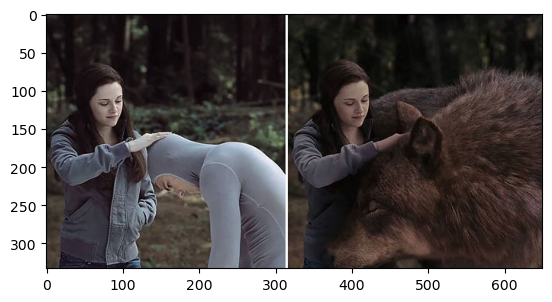

In [5]:
plt.imshow(X[0]) #ploting the first enrty

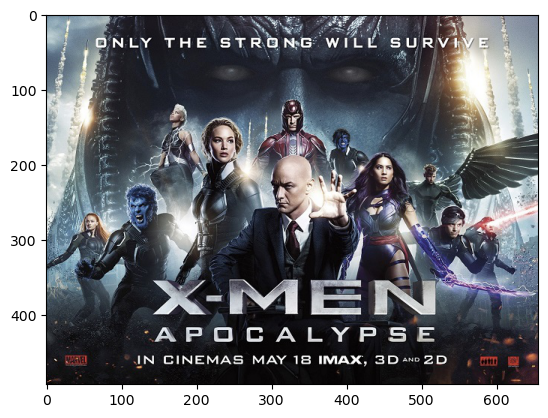

In [6]:
plt.imshow(X[408]) #ploting the ramdon entry

In [7]:
#shape of random Images
display(X[0].shape)
display(X[333].shape)
display(X[408].shape)

(333, 650, 3)

(678, 1024, 3)

(493, 656, 3)

In [8]:
#unifing shape using cv2
from tensorflow.keras.applications.mobilenet import preprocess_input
#setting teh image width,heigth and alpha
img_width = 224
img_height = 224
alpha =1

#zero arrays with image width, height and channel
X = np.zeros((int(image_data.shape[0]),img_height,img_width,3))
y = np.zeros((int(image_data.shape[0]),img_height,img_width))

#for loop for changing the shape of every image and store in the image
for index in range(image_data.shape[0]):
    img = image_data[index][0]
    img = cv2.resize(img,dsize=(img_height,img_width),interpolation=cv2.INTER_CUBIC)
    try:
        img = img[:,:,:3]
    except:
        continue
    X[index] = preprocess_input(np.array(img,dtype=np.float32))
    for i in image_data[index][1]:
        x1 = int(i["points"][0]['x'] * img_width)
        x2 = int(i["points"][1]['x'] * img_width)
        y1 = int(i["points"][0]['y'] * img_height)
        y2 = int(i["points"][1]['y'] * img_height)
        y[index][y1:y2, x1:x2] = 1

<span style="font-family:Ebrima; font-weight:bold;font-size:1.5em;color:#b44b97;">1 c - Split the data into train and test [400:9]

In [9]:
#using the train_test_split function dividing the 400:9
Xtrain,Xtest,ytrain,ytest = train_test_split(X,y,test_size=9,random_state=12)

In [10]:
#shape report
display(Xtrain.shape)
display(Xtest.shape)
display(ytrain.shape)
display(ytest.shape)

(400, 224, 224, 3)

(9, 224, 224, 3)

(400, 224, 224)

(9, 224, 224)

<span style="font-family:Ebrima; font-weight:bold;font-size:1.5em;color:#b44b97;">1 d - Select random image from the train data and display original image and masked image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

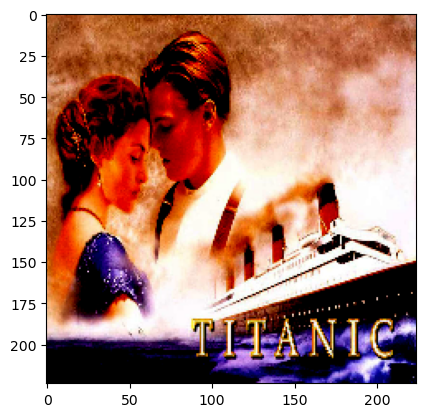

In [11]:
#Selecting the random Image
rand_num = np.random.randint(0,image_data.shape[0])
plt.imshow(X[rand_num])
y[rand_num]

<span style="font-family:Ebrima; font-weight:bold;font-size:1.5em;color:#b44b97;">2 a - Design a face mask detection model

In [12]:
# Model Design using the Mobile Net for face detection
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Concatenate,UpSampling2D,Reshape,Conv2D
from tensorflow.keras.models import Model

In [13]:
#including the mobile net with the parameters and weigth
model = MobileNet(input_shape=(224,224,3),
                  include_top=False,
                  alpha=1,
                  weights="imagenet")
#model summary
model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

                                                                 
 conv_pw_8_bn (BatchNormaliz  (None, 14, 14, 512)      2048      
 ation)                                                          
                                                                 
 conv_pw_8_relu (ReLU)       (None, 14, 14, 512)       0         
                                                                 
 conv_dw_9 (DepthwiseConv2D)  (None, 14, 14, 512)      4608      
                                                                 
 conv_dw_9_bn (BatchNormaliz  (None, 14, 14, 512)      2048      
 ation)                                                          
                                                                 
 conv_dw_9_relu (ReLU)       (None, 14, 14, 512)       0         
                                                                 
 conv_pw_9 (Conv2D)          (None, 14, 14, 512)       262144    
                                                                 
 conv_pw_9

In [14]:
#adjusting the model
def create_model(trainable=False):
    #base Imagenet Model
    model = MobileNet(input_shape=(224,224,3),include_top=False,alpha=1,weights="imagenet")
    
    #seeting traiable parameters
    for layer in model.layers:
        layer.trainable = trainable
    
    #geeting blocks of input layers
    block00 = model.layers[0].input
    block01 = model.get_layer('conv_pw_1_relu').output
    block02 = model.get_layer('conv_pw_2_relu').output
    block03 = model.get_layer('conv_pw_3_relu').output
    block05 = model.get_layer('conv_pw_5_relu').output
    block11 = model.get_layer('conv_pw_11_relu').output
    block13 = model.get_layer('conv_pw_13_relu').output
    
    #adding the Upsampling and decoder block in block 00,01,03,05,11
    decoderBlock = Concatenate()([UpSampling2D()(block13),block11])
    decoderBlock = Concatenate()([UpSampling2D()(decoderBlock),block05])
    decoderBlock = Concatenate()([UpSampling2D()(decoderBlock),block03])
    decoderBlock = Concatenate()([UpSampling2D()(decoderBlock),block01])
    decoderBlock = Concatenate()([UpSampling2D()(decoderBlock),block00])
    
    #convloution layer
    decoderBlock = Conv2D(1,kernel_size=1,activation='sigmoid')(decoderBlock)
    decoderBlock = Reshape((224,224))(decoderBlock)
    
    #model return decoder block
    return Model(inputs=model.input, outputs=decoderBlock)

<span style="font-family:Ebrima; font-weight:bold;font-size:1.5em;color:#b44b97;">2 b - Design your own Dice Coefficient and Loss function

In [15]:
#Dice Coefficient function
def dice_coef(y_true,y_pred):
    #calculating numerator and Denominator for the dice coefficenet
    numerator = 2* tf.reduce_sum(y_true *y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)
    #dice coefficeient
    dice_coefficient = numerator/(denominator + tf.keras.backend.epsilon())
    return dice_coefficient

In [16]:
#Loss fuction
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.backend import log, epsilon
def loss(y_true,y_pred):
    loss = binary_crossentropy(y_true,y_pred) - log(dice_coef(y_true,y_pred)+epsilon())
    return loss

<span style="font-family:Ebrima; font-weight:bold;font-size:1.5em;color:#b44b97;">2 c - Train and tune the model as required

In [17]:
#calling the Model fuction
model = create_model(False)
model.summary()

#Defining the optimizer parameter
optimizer= tf.keras.optimizers.legacy.Adam(learning_rate=1e-4,beta_1=0.9,beta_2=0.999,epsilon=None,decay=0.0,amsgrad=False)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 112, 112, 32  128         ['conv1[0][0]']                  
                                )                                                             

 on)                                                                                              
                                                                                                  
 conv_dw_5_relu (ReLU)          (None, 28, 28, 256)  0           ['conv_dw_5_bn[0][0]']           
                                                                                                  
 conv_pw_5 (Conv2D)             (None, 28, 28, 256)  65536       ['conv_dw_5_relu[0][0]']         
                                                                                                  
 conv_pw_5_bn (BatchNormalizati  (None, 28, 28, 256)  1024       ['conv_pw_5[0][0]']              
 on)                                                                                              
                                                                                                  
 conv_pw_5_relu (ReLU)          (None, 28, 28, 256)  0           ['conv_pw_5_bn[0][0]']           
          

 conv_dw_11 (DepthwiseConv2D)   (None, 14, 14, 512)  4608        ['conv_pw_10_relu[0][0]']        
                                                                                                  
 conv_dw_11_bn (BatchNormalizat  (None, 14, 14, 512)  2048       ['conv_dw_11[0][0]']             
 ion)                                                                                             
                                                                                                  
 conv_dw_11_relu (ReLU)         (None, 14, 14, 512)  0           ['conv_dw_11_bn[0][0]']          
                                                                                                  
 conv_pw_11 (Conv2D)            (None, 14, 14, 512)  262144      ['conv_dw_11_relu[0][0]']        
                                                                                                  
 conv_pw_11_bn (BatchNormalizat  (None, 14, 14, 512)  2048       ['conv_pw_11[0][0]']             
 ion)     

In [18]:
#model compile
model.compile(loss=loss,optimizer=optimizer,metrics=[dice_coef])

In [19]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
#checkpoint with its parameters
checkpoint = ModelCheckpoint("model-{loss:.2f}.h5",
                            monitor="loss",verbose=1,
                            save_best_only = True,save_weights_only = True,
                             mode = "min",save_freq=1)
#earlystopping
stop = EarlyStopping(monitor='loss',patience=5,mode='min')
reduce_lr = ReduceLROnPlateau(monitor='loss',factor=0.2,patience=1,min_lr=1e-6,mode=min)

In [20]:
#fitting the Model
model.fit(Xtrain,ytrain,epochs=5,verbose=1,batch_size=3,callbacks=[checkpoint,reduce_lr,stop])

Epoch 1/5

Epoch 1: loss improved from inf to 2.62390, saving model to model-2.62.h5
  1/134 [..............................] - ETA: 18:22 - loss: 2.6239 - dice_coef: 0.1388
Epoch 1: loss improved from 2.62390 to 2.58748, saving model to model-2.59.h5
  2/134 [..............................] - ETA: 3:35 - loss: 2.5875 - dice_coef: 0.1650 
Epoch 1: loss improved from 2.58748 to 2.41431, saving model to model-2.41.h5
  3/134 [..............................] - ETA: 3:55 - loss: 2.4143 - dice_coef: 0.2025
Epoch 1: loss did not improve from 2.41431
  4/134 [..............................] - ETA: 3:52 - loss: 2.6516 - dice_coef: 0.1699
Epoch 1: loss did not improve from 2.41431
  5/134 [>.............................] - ETA: 3:41 - loss: 2.6475 - dice_coef: 0.1643
Epoch 1: loss did not improve from 2.41431
  6/134 [>.............................] - ETA: 3:37 - loss: 2.6715 - dice_coef: 0.1589
Epoch 1: loss did not improve from 2.41431
  7/134 [>.............................] - ETA: 3:32 - lo

 62/134 [============>.................] - ETA: 1:34 - loss: 2.3954 - dice_coef: 0.1929
Epoch 1: loss improved from 2.39414 to 2.38937, saving model to model-2.39.h5
 63/134 [=============>................] - ETA: 1:33 - loss: 2.3894 - dice_coef: 0.1929
Epoch 1: loss improved from 2.38937 to 2.38491, saving model to model-2.38.h5
 64/134 [=============>................] - ETA: 1:32 - loss: 2.3849 - dice_coef: 0.1929
Epoch 1: loss improved from 2.38491 to 2.37851, saving model to model-2.38.h5
 65/134 [=============>................] - ETA: 1:30 - loss: 2.3785 - dice_coef: 0.1937
Epoch 1: loss improved from 2.37851 to 2.37485, saving model to model-2.37.h5
 66/134 [=============>................] - ETA: 1:29 - loss: 2.3748 - dice_coef: 0.1935
Epoch 1: loss improved from 2.37485 to 2.36327, saving model to model-2.36.h5
 67/134 [==============>...............] - ETA: 1:28 - loss: 2.3633 - dice_coef: 0.1953
Epoch 1: loss improved from 2.36327 to 2.35474, saving model to model-2.35.h5
 68/

 36/134 [=======>......................] - ETA: 2:02 - loss: 1.5720 - dice_coef: 0.3248
Epoch 2: loss did not improve from 1.41321
 37/134 [=======>......................] - ETA: 2:00 - loss: 1.5671 - dice_coef: 0.3264
Epoch 2: loss did not improve from 1.41321
 38/134 [=======>......................] - ETA: 1:59 - loss: 1.5647 - dice_coef: 0.3265
Epoch 2: loss did not improve from 1.41321
 39/134 [=======>......................] - ETA: 1:58 - loss: 1.5519 - dice_coef: 0.3301
Epoch 2: loss did not improve from 1.41321
 40/134 [=======>......................] - ETA: 1:56 - loss: 1.5466 - dice_coef: 0.3324
Epoch 2: loss did not improve from 1.41321
 41/134 [========>.....................] - ETA: 1:55 - loss: 1.5362 - dice_coef: 0.3358
Epoch 2: loss did not improve from 1.41321
 42/134 [========>.....................] - ETA: 1:54 - loss: 1.5539 - dice_coef: 0.3318
Epoch 2: loss did not improve from 1.41321
 43/134 [========>.....................] - ETA: 1:52 - loss: 1.5617 - dice_coef: 0.

 22/134 [===>..........................] - ETA: 2:13 - loss: 1.1270 - dice_coef: 0.4413
Epoch 3: loss did not improve from 0.96761
 23/134 [====>.........................] - ETA: 2:11 - loss: 1.1241 - dice_coef: 0.4408
Epoch 3: loss did not improve from 0.96761
 24/134 [====>.........................] - ETA: 2:10 - loss: 1.1381 - dice_coef: 0.4341
Epoch 3: loss did not improve from 0.96761
 25/134 [====>.........................] - ETA: 2:09 - loss: 1.1331 - dice_coef: 0.4379
Epoch 3: loss did not improve from 0.96761
 26/134 [====>.........................] - ETA: 2:08 - loss: 1.1282 - dice_coef: 0.4409
Epoch 3: loss did not improve from 0.96761
 27/134 [=====>........................] - ETA: 2:06 - loss: 1.1379 - dice_coef: 0.4379
Epoch 3: loss did not improve from 0.96761
 28/134 [=====>........................] - ETA: 2:05 - loss: 1.1373 - dice_coef: 0.4364
Epoch 3: loss did not improve from 0.96761
 29/134 [=====>........................] - ETA: 2:04 - loss: 1.1603 - dice_coef: 0.

 12/134 [=>............................] - ETA: 2:23 - loss: 0.9882 - dice_coef: 0.4787
Epoch 4: loss did not improve from 0.90650
 13/134 [=>............................] - ETA: 2:22 - loss: 0.9846 - dice_coef: 0.4806
Epoch 4: loss did not improve from 0.90650
 14/134 [==>...........................] - ETA: 2:21 - loss: 0.9787 - dice_coef: 0.4825
Epoch 4: loss did not improve from 0.90650
 15/134 [==>...........................] - ETA: 2:20 - loss: 0.9887 - dice_coef: 0.4792
Epoch 4: loss did not improve from 0.90650
 16/134 [==>...........................] - ETA: 2:19 - loss: 0.9739 - dice_coef: 0.4881
Epoch 4: loss did not improve from 0.90650
 17/134 [==>...........................] - ETA: 2:18 - loss: 1.0220 - dice_coef: 0.4732
Epoch 4: loss did not improve from 0.90650
 18/134 [===>..........................] - ETA: 2:17 - loss: 1.0337 - dice_coef: 0.4732
Epoch 4: loss did not improve from 0.90650
 19/134 [===>..........................] - ETA: 2:15 - loss: 1.0174 - dice_coef: 0.

  3/134 [..............................] - ETA: 2:36 - loss: 1.1214 - dice_coef: 0.4349
Epoch 5: loss did not improve from 0.90650
  4/134 [..............................] - ETA: 2:34 - loss: 1.0324 - dice_coef: 0.4727
Epoch 5: loss did not improve from 0.90650
  5/134 [>.............................] - ETA: 2:36 - loss: 1.0027 - dice_coef: 0.5027
Epoch 5: loss did not improve from 0.90650
  6/134 [>.............................] - ETA: 2:35 - loss: 0.9860 - dice_coef: 0.5068
Epoch 5: loss did not improve from 0.90650
  7/134 [>.............................] - ETA: 2:35 - loss: 0.9659 - dice_coef: 0.5064
Epoch 5: loss did not improve from 0.90650
  8/134 [>.............................] - ETA: 2:35 - loss: 0.9672 - dice_coef: 0.5010
Epoch 5: loss did not improve from 0.90650
  9/134 [=>............................] - ETA: 2:34 - loss: 0.9444 - dice_coef: 0.5097
Epoch 5: loss did not improve from 0.90650
 10/134 [=>............................] - ETA: 2:33 - loss: 0.9077 - dice_coef: 0.

 65/134 [=============>................] - ETA: 1:31 - loss: 0.9732 - dice_coef: 0.5017
Epoch 5: loss did not improve from 0.87464
 66/134 [=============>................] - ETA: 1:29 - loss: 0.9842 - dice_coef: 0.4975
Epoch 5: loss did not improve from 0.87464
 67/134 [==============>...............] - ETA: 1:28 - loss: 0.9847 - dice_coef: 0.4970
Epoch 5: loss did not improve from 0.87464
 68/134 [==============>...............] - ETA: 1:26 - loss: 0.9871 - dice_coef: 0.4954
Epoch 5: loss did not improve from 0.87464
 69/134 [==============>...............] - ETA: 1:25 - loss: 0.9856 - dice_coef: 0.4949
Epoch 5: loss did not improve from 0.87464
 70/134 [==============>...............] - ETA: 1:24 - loss: 0.9876 - dice_coef: 0.4949
Epoch 5: loss did not improve from 0.87464
 71/134 [==============>...............] - ETA: 1:22 - loss: 0.9838 - dice_coef: 0.4962
Epoch 5: loss did not improve from 0.87464
 72/134 [===============>..............] - ETA: 1:21 - loss: 0.9828 - dice_coef: 0.

128/134 [===========================>..] - ETA: 7s - loss: 0.9514 - dice_coef: 0.5116
Epoch 5: loss did not improve from 0.87464
129/134 [===========================>..] - ETA: 6s - loss: 0.9509 - dice_coef: 0.5117
Epoch 5: loss did not improve from 0.87464
130/134 [============================>.] - ETA: 5s - loss: 0.9505 - dice_coef: 0.5117
Epoch 5: loss did not improve from 0.87464
131/134 [============================>.] - ETA: 3s - loss: 0.9511 - dice_coef: 0.5114
Epoch 5: loss did not improve from 0.87464
132/134 [============================>.] - ETA: 2s - loss: 0.9486 - dice_coef: 0.5123
Epoch 5: loss did not improve from 0.87464
133/134 [============================>.] - ETA: 1s - loss: 0.9467 - dice_coef: 0.5128
Epoch 5: loss did not improve from 0.87464
134/134 [==============================] - 170s 1s/step - loss: 0.9460 - dice_coef: 0.5135 - lr: 1.0000e-04


<span style="font-family:Ebrima; font-weight:bold;font-size:1.5em;color:#b44b97;">2 d - Evaluate and share insights on performance of the model.

In [21]:
#evaluating Model with the Test Data
model.evaluate(Xtest,ytest)

1/1 [==============================] - 23s 23s/step - loss: 0.7509 - dice_coef: 0.5932


[0.7509078979492188, 0.5932361483573914]

In [22]:
#making Prediction
ypred = model.predict(Xtest)

1/1 [==============================] - 15s 15s/step


<span style="font-family:Ebrima; font-weight:bold;font-size:1.5em;color:#b44b97;">3 - Test the model predictions on the test image: ‘image with index 3 in the test data’ and visualise the predicted masks on the faces in the image.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


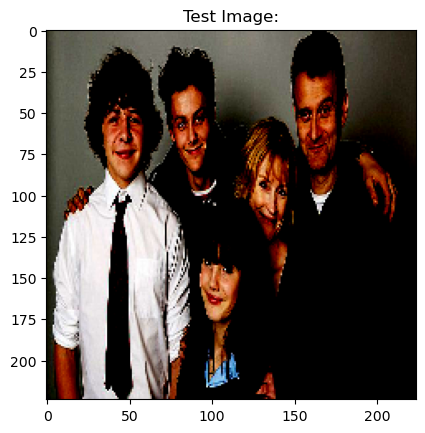

In [23]:
#selecting thr 3rd image from the test data
plt.imshow(Xtest[3])
plt.title("Test Image:")
plt.show()

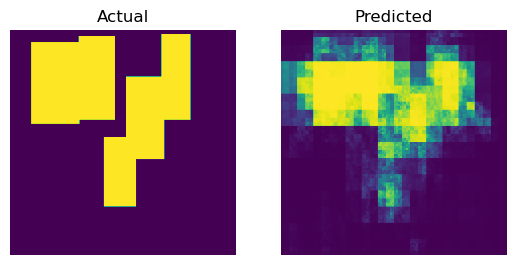

In [24]:
#plotting Actual 
plt.subplot(1,2,1)
plt.imshow(ytest[3])
plt.title("Actual")
plt.axis(False)

#ploting Prection
plt.subplot(1,2,2)
plt.imshow(ypred[3])
plt.title("Predicted")
plt.axis(False)
plt.show()


<span style="font-family:Ebrima; font-weight:bold;font-size:2.5em;color:#b44b97;"> Part B

<span style="font-family:Ebrima; font-weight:bold;font-size:1em;color:#3A8D71;">DOMAIN:</span> Entertainment

<span style="font-family:Ebrima; font-weight:bold;font-size:1em;color:#3A8D71;">CONTENT:</span> Company X owns a movie application and repository which caters movie streaming to millions of users who on subscription
basis. Company wants to automate the process of cast and crew information in each scene from a movie such that when a user pauses on
the movie and clicks on cast information button, the app will show details of the actor in the scene. Company has an in-house computer
vision and multimedia experts who need to detect faces from screen shots from the movie scene.
The data labelling is already done. Since there higher time complexity is involved in the

<span style="font-family:Ebrima; font-weight:bold;font-size:1em;color:#3A8D71;">DATA DESCRIPTION:</span>The dataset comprises of face images.

<span style="font-family:Ebrima; font-weight:bold;font-size:1em;color:#3A8D71;">PROJECT OBJECTIVE:</span> To create an image dataset to be used by AI team build an image classifier data. Profile images of people are given.

<span style="font-family:Ebrima; font-weight:bold;font-size:1.5em;color:#b44b97;">1 a Read/import images from folder ‘training_images’

In [25]:
#loading the training _image floder
img_dir = 'D:/Course/Great Lakhs/Projects/8. Computer Vision/Project 2/training_images/'
os.listdir(img_dir)

#function to join all the images in the folder
def load_image(folder):
    #empty list
    image = [] 
    file_name = []
    #for loop over the root folder
    for filename in os.listdir(folder):
        file_name.append(filename)
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            image.append(img) #joining the readed image
    return image,file_name

In [26]:
image,file_name = load_image(img_dir) #loading image and file name for the function

In [27]:
len(image) #count the image

1091

<span style="font-family:Ebrima; font-weight:bold;font-size:1.5em;color:#b44b97;">1 b - Write a loop which will iterate through all the images in the ‘training_images’ folder and detect the faces present on all the images

In [28]:
#function to detect the face in the all the images with the CascadeClassifier pre build function\

import cv2
trained_face_data = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
#empty list to stroe the extracting infromation
face_images = []
image_face_coordinates = []
x_axis = []
y_axis = []
width = []
height = []
face_count=[]

for img in image:
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) #chaing image to grayscale to find the difference
    face_coordinates = trained_face_data.detectMultiScale(gray_img)  #getting the face coordinated using the trained_face_data.detectMultiScale from gray scale
    image_face_coordinates.append(face_coordinates) #stroe the coordinate in list
    count=0 #for count the images
    for coordinate in face_coordinates:
        (x, y, w, h) = coordinate
        #spling and storing all the coordinates into multiple list
        x_axis.append(x)
        y_axis.append(y)
        width.append(w)
        height.append(h)
        colors = np.random.randint(1, 255, 3)
        #drawig the recctangle over the diected face
        img = cv2.rectangle(img, (x, y), (x + w, y + h), (int(colors[0]), int(colors[1]), int(colors[2])), thickness=2)
        count+=1
        face_count.append(count)
        #if cooredianet vlaue is null store in face image list
    if face_coordinates != ():
        face_images.append(img)

In [29]:
len(face_images)

962

Observation:

The Length of the list Images and Face Images confirms that all the images in the training data as Face.

<span style="font-family:Ebrima; font-weight:bold;font-size:1.5em;color:#b44b97;">1 c - From the same loop above, extract metadata of the faces and write into a DataFrame.

In [30]:
#creating the Dataframe
image_data = pd.DataFrame({'X-Axis':x_axis,'Y-Axis':y_axis,'Width':width,'Height':height,'No.of.Face':face_count})

In [31]:
#first 10 entires
image_data[:10]

,X-Axis,Y-Axis,Width,Height,No.of.Face
0,146,140,428,428,1
1,80,140,436,436,1
2,33,121,362,362,1
3,91,28,90,90,1
4,134,173,356,356,2
5,13,12,162,162,3
6,344,75,110,110,1
7,61,62,472,472,1
8,222,213,83,83,1
9,328,432,83,83,1


<span style="font-family:Ebrima; font-weight:bold;font-size:1.5em;color:#b44b97;">1 d - Save the output Dataframe in .csv format

In [32]:
#saving the dataframe into excel
image_data.to_csv('image_data.csv')

<span style="font-family:Ebrima; font-weight:bold;font-size:2.5em;color:#b44b97;"> Part C

<span style="font-family:Ebrima; font-weight:bold;font-size:1em;color:#3A8D71;">DOMAIN:</span> Botanical Research

<span style="font-family:Ebrima; font-weight:bold;font-size:1em;color:#3A8D71;">CONTENT:</span> University X is currently undergoing some research involving understanding the characteristics of plant and plant seedlings at
various stages of growth. They already have have invested on curating sample images. They require an automation which can create a
classifier capable of determining a plant's species from a photo.

<span style="font-family:Ebrima; font-weight:bold;font-size:1em;color:#3A8D71;">DATA DESCRIPTION:</span> The dataset comprises of images from 12 plant species.

<span style="font-family:Ebrima; font-weight:bold;font-size:1em;color:#3A8D71;">PROJECT OBJECTIVE:</span> To create a classifier capable of determining a plant's species from a photo.

<span style="font-family:Ebrima; font-weight:bold;font-size:1.5em;color:#b44b97;">1 a - Unzip, read and Load data(‘PINS.zip’) into session

In [33]:
#import ing Zip
from zipfile import ZipFile

#root folder path
image_path = "D:/Course/Great Lakhs/Projects/8. Computer Vision/Project 2/PINS.zip"

#extracting the zip file
with ZipFile(image_path, 'r') as z:
  z.extractall()

<span style="font-family:Ebrima; font-weight:bold;font-size:1.5em;color:#b44b97;">1 b - Write function to create metadata of the image

In [34]:
#function for 
import numpy as np
import os

class IdentityMetadata():
    def __init__(self, base, name, file):
        # print(base, name, file)
        # dataset base directory
        self.base = base
        # identity name
        self.name = name
        # image file name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file) 

#function for getting meta data of the file in the extracted zip folder    
def load_metadata(path):
    metadata = []
    for i in os.listdir(path):
        for f in os.listdir(os.path.join(path, i)):
            # Check file extension. Allow only jpg/jpeg' files.
            ext = os.path.splitext(f)[1]
            if ext == '.jpg' or ext == '.jpeg':
                metadata.append(IdentityMetadata(path, i, f))
    return np.array(metadata)

# metadata = load_metadata('images')
metadata = load_metadata('PINS')

<span style="font-family:Ebrima; font-weight:bold;font-size:1.5em;color:#b44b97;">1 c - Write a loop to iterate through each and every image and create metadata for all the images.

In [35]:
import cv2
def load_image(path):
    img = cv2.imread(path, 1)
    # OpenCV loads images with color channels
    # in BGR order. So we need to reverse them
    return img[...,::-1]

In [36]:
load_image("D:/Course/Great Lakhs/Projects/8. Computer Vision/Project 2/PINS/pins_bill gates/bill gates27.jpg")

array([[[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       ...,

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [42, 44, 41],
        [ 1,  3,  2],
        [ 0,  0,  0]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 9, 11, 10],
        [ 0,  1,  0],
        [ 3,  3,  5]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 0,  1,  0],
        [ 1,  1,  3],
        [ 4,  2,  5]]], dtype=uint8)

<span style="font-family:Ebrima; font-weight:bold;font-size:1.5em;color:#b44b97;">1 d - Generate Embeddings vectors on the each face in the dataset.

In [37]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ZeroPadding2D, Convolution2D, MaxPooling2D, Dropout, Flatten, Activation

def vgg_face():	
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(Convolution2D(4096, (7, 7), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(4096, (1, 1), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(2622, (1, 1)))
    model.add(Flatten())
    model.add(Activation('softmax'))
    return model

In [38]:
#addding VGG face model
model = vgg_face()
model.load_weights("D:/Course/Great Lakhs/Projects/8. Computer Vision/Project 2/vgg_face_weights.h5")

model.layers[0], model.layers[-2]

(<keras.layers.reshaping.zero_padding2d.ZeroPadding2D at 0x1d20073e560>,
 <keras.layers.reshaping.flatten.Flatten at 0x1d2007a38e0>)

In [39]:
from tensorflow.keras.models import Model
vgg_face_descriptor = Model(inputs=model.layers[0].input, outputs=model.layers[-2].output)

type(vgg_face_descriptor)

keras.engine.functional.Functional

In [40]:
vgg_face_descriptor.inputs, vgg_face_descriptor.outputs

([<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'zero_padding2d_input')>],
 [<KerasTensor: shape=(None, 2622) dtype=float32 (created by layer 'flatten')>])

In [41]:
# Get embedding vector for first image in the metadata using the pre-trained model
img_path = metadata[0].image_path()
img = load_image(img_path)

# Normalising pixel values from [0-255] to [0-1]: scale RGB values to interval [0,1]
img = (img / 255.).astype(np.float32)
img = cv2.resize(img, dsize = (224,224))
print(img.shape)

# Obtain embedding vector for an image
# Get the embedding vector for the above image using vgg_face_descriptor model and print the shape 
embedding_vector = vgg_face_descriptor.predict(np.expand_dims(img, axis=0))[0]
print(embedding_vector.shape)

(224, 224, 3)
1/1 [==============================] - 1s 520ms/step
(2622,)


In [42]:
embedding_vector[0], type(embedding_vector), type(embedding_vector[0])

(0.03170304, numpy.ndarray, numpy.float32)

In [43]:
embedding_vector[2], embedding_vector[98], embedding_vector[-2]

(-0.012434014, -0.008693827, 0.002190806)

In [44]:
total_images = len(metadata)

In [45]:
embeddings = np.zeros((metadata.shape[0], 2622))
for i, m in enumerate(metadata):
    img_path = metadata[i].image_path()
    img = load_image(img_path)
    img = (img / 255.).astype(np.float32)
    img = cv2.resize(img, dsize = (224,224))
    embedding_vector = vgg_face_descriptor.predict(np.expand_dims(img, axis=0))[0]
    embeddings[i]=embedding_vector

1/1 [==============================] - 0s 309ms/step


1/1 [==============================] - 0s 223ms/step


1/1 [==============================] - 0s 200ms/step


1/1 [==============================] - 0s 249ms/step


1/1 [==============================] - 0s 248ms/step


1/1 [==============================] - 0s 249ms/step


1/1 [==============================] - 0s 242ms/step


1/1 [==============================] - 0s 218ms/step


1/1 [==============================] - 0s 252ms/step


1/1 [==============================] - 0s 222ms/step


1/1 [==============================] - 0s 280ms/step


1/1 [==============================] - 0s 296ms/step


1/1 [==============================] - 0s 282ms/step


1/1 [==============================] - 0s 378ms/step


1/1 [==============================] - 0s 382ms/step


1/1 [==============================] - 0s 409ms/step


1/1 [==============================] - 0s 419ms/step


1/1 [==============================] - 0s 447ms/step


1/1 [==============================] - 0s 493ms/step


1/1 [==============================] - 0s 485ms/step


1/1 [==============================] - 0s 497ms/step


1/1 [==============================] - 1s 552ms/step


1/1 [==============================] - 1s 522ms/step


1/1 [==============================] - 1s 627ms/step


1/1 [==============================] - 1s 737ms/step


1/1 [==============================] - 1s 668ms/step


1/1 [==============================] - 1s 691ms/step


1/1 [==============================] - 1s 809ms/step


1/1 [==============================] - 1s 773ms/step


1/1 [==============================] - 1s 977ms/step


1/1 [==============================] - 1s 989ms/step


1/1 [==============================] - 1s 1s/step


1/1 [==============================] - 1s 1s/step


1/1 [==============================] - 2s 2s/step


1/1 [==============================] - 2s 2s/step


1/1 [==============================] - 2s 2s/step


In [46]:
print('embeddings shape :', embeddings.shape)

embeddings shape : (10770, 2622)


In [47]:
embeddings[0], embeddings[988], embeddings[988].shape

(array([ 0.03170304, -0.01505131, -0.01243401, ...,  0.0004314 ,
         0.00219081, -0.00908097]),
 array([ 0.00793027,  0.00865318, -0.00304816, ..., -0.01746992,
         0.02693006,  0.00946763]),
 (2622,))

In [48]:
embeddings[8275]

array([-0.00299085,  0.00685951,  0.01823113, ..., -0.01414709,
        0.03610871,  0.01799196])

<span style="font-family:Ebrima; font-weight:bold;font-size:1.5em;color:#b44b97;">1 e - Build distance metrics for identifying the distance between two similar and dissimilar images.

In [49]:
#function to caluate the distance between the images
def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

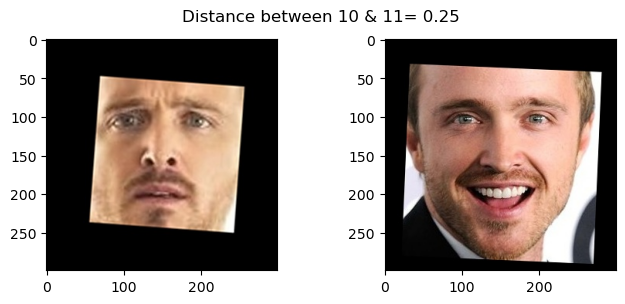

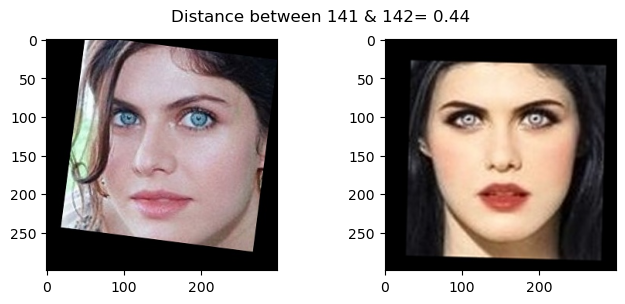

In [50]:
#function for distance metrics for identify the distance
def show_pair(idx1, idx2):
    plt.figure(figsize=(8,3))
    #title the distacne between the images by calling the distance function
    plt.suptitle(f'Distance between {idx1} & {idx2}= {distance(embeddings[idx1], embeddings[idx2]):.2f}')
    plt.subplot(121)
    plt.imshow(load_image(metadata[idx1].image_path()))
    plt.subplot(122)
    plt.imshow(load_image(metadata[idx2].image_path()));    

show_pair(10, 11)
show_pair(141, 142)

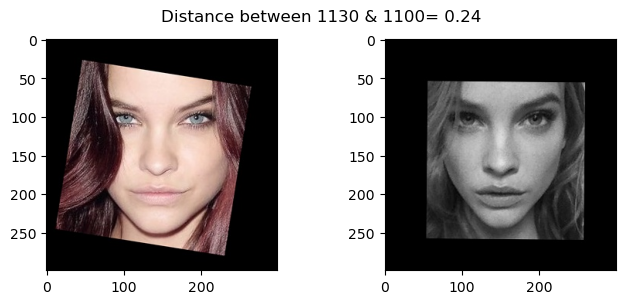

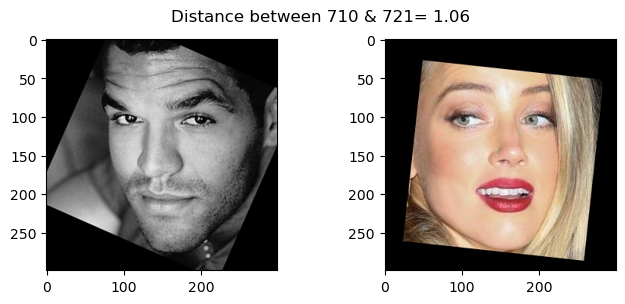

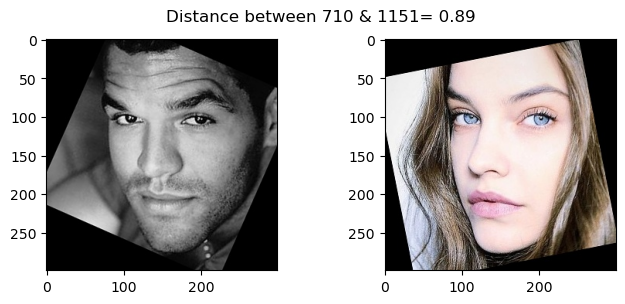

In [51]:
show_pair(1130, 1100)
show_pair(710, 721)
show_pair(710, 1151)

<span style="font-family:Ebrima; font-weight:bold;font-size:1.5em;color:#b44b97;">1 f - Use PCA for dimensionality reduction

In [52]:
train_idx = np.arange(metadata.shape[0]) % 9 != 0     
test_idx = np.arange(metadata.shape[0]) % 9 == 0

# one half as train examples of 10 identities
X_train = embeddings[train_idx]

# another half as test examples of 10 identities
X_test = embeddings[test_idx]
targets = np.array([m.name for m in metadata])

#train labels
y_train = targets[train_idx]

#test labels
y_test = targets[test_idx]

print('X_train shape : ({0},{1})'.format(X_train.shape[0], X_train.shape[1]))
print('y_train shape : ({0},)'.format(y_train.shape[0]))
print('X_test shape : ({0},{1})'.format(X_test.shape[0], X_test.shape[1]))
print('y_test shape : ({0},)'.format(y_test.shape[0]))

X_train shape : (9573,2622)
y_train shape : (9573,)
X_test shape : (1197,2622)
y_test shape : (1197,)


In [54]:
Xtrain.shape

(400, 224, 224, 3)

In [55]:
y_test[0], y_train[72]
len(np.unique(y_test)), len(np.unique(y_train))

(100, 100)

In [56]:
#instance for Label Encoder
from sklearn.preprocessing import LabelEncoder
#fit and Transforming the ytrain
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)

In [57]:
print(le.classes_)
y_test_encoded = le.transform(y_test)

['pins_Aaron Paul' 'pins_Alvaro Morte' 'pins_Amanda Crew'
 'pins_Amaury Nolasco' 'pins_Anna Gunn' 'pins_Benedict Cumberbatch'
 'pins_Betsy Brandt' 'pins_Brenton Thwaites' 'pins_Brit Marling'
 'pins_Bryan Cranston' 'pins_Caity Lotz' 'pins_Cameron Monaghan'
 'pins_Chance Perdomo' 'pins_Chris Evans' 'pins_Chris Pratt'
 'pins_Cobie Smulders' 'pins_Danielle Panabaker' 'pins_Dave Franco'
 'pins_Dominic Purcell' 'pins_Dwayne Johnson' 'pins_Emilia Clarke'
 'pins_Emily Bett Rickards' 'pins_Emma Stone' 'pins_Gwyneth Paltrow'
 'pins_Henry Cavil' 'pins_Jason Momoa' 'pins_Jeremy Renner'
 'pins_Jesse Eisenberg' 'pins_Jim Parsons' 'pins_Jon Bernthal'
 'pins_Josh Radnor' 'pins_Kit Harington' 'pins_Krysten Ritter'
 'pins_Kumail Nanjiani' 'pins_Maisie Williams' 'pins_Mark Ruffalo'
 'pins_Martin Starr' 'pins_Melissa benoit' 'pins_Mike Colter'
 'pins_Morena Baccarin' 'pins_Morgan Freeman' 'pins_Natalie Portman'
 'pins_Neil Patrick Harris' 'pins_Paul Rudd' 'pins_Pedro Alonso'
 'pins_Peter Dinklage' 'pins_R

In [58]:
print('y_train_encoded : ', y_train_encoded)
print('y_test_encoded : ', y_test_encoded)

y_train_encoded :  [ 0  0  0 ... 99 99 99]
y_test_encoded :  [ 0  0  0 ... 99 99 99]


In [59]:
# Standarize features
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.fit_transform(X_test)

In [60]:
X_train[0].shape

(2622,)

In [61]:
X_train_std[0].shape

(2622,)

In [62]:
#train and Test Data Shapes
print('X_train_std shape : ({0},{1})'.format(X_train_std.shape[0], X_train_std.shape[1]))
print('y_train_encoded shape : ({0},)'.format(y_train_encoded.shape[0]))
print('X_test_std shape : ({0},{1})'.format(X_test_std.shape[0], X_test_std.shape[1]))
print('y_test_encoded shape : ({0},)'.format(y_test_encoded.shape[0]))

X_train_std shape : (9573,2622)
y_train_encoded shape : (9573,)
X_test_std shape : (1197,2622)
y_test_encoded shape : (1197,)


In [63]:
X_train_std.shape

(9573, 2622)

In [64]:
#PCA for the Xtrain and Xtest with n_compentents 128
from sklearn.decomposition import PCA

pca = PCA(n_components=128,svd_solver='auto')
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

In [65]:
#shape of Xtrain after PCA
X_train_pca.shape

(9573, 128)

<span style="font-family:Ebrima; font-weight:bold;font-size:1.5em;color:#b44b97;">1 g - Build an SVM classifier in order to map each image to its right person

In [66]:
#building SVC Model

from sklearn.svm import SVC

clf = SVC(C=5., gamma=0.001)
clf.fit(X_train_pca, y_train_encoded)

SVC(C=5.0, gamma=0.001)

In [67]:
#model Prediction
y_predict = clf.predict(X_test_pca)

In [68]:
#printing Prediction
print('y_predict : ',y_predict)
print('y_test_encoded : ',y_test_encoded)

y_predict :  [ 0  0  0 ... 99 99 99]
y_test_encoded :  [ 0  0  0 ... 99 99 99]


In [69]:
#accaracy Score
accuracy_score(y_predict,y_test_encoded)

0.9507101086048454

In [70]:
#inversing using the Label encoder 
y_predict_encoded = le.inverse_transform(y_predict)

<span style="font-family:Ebrima; font-weight:bold;font-size:1.5em;color:#b44b97;">1 h - Import and display the the test images.

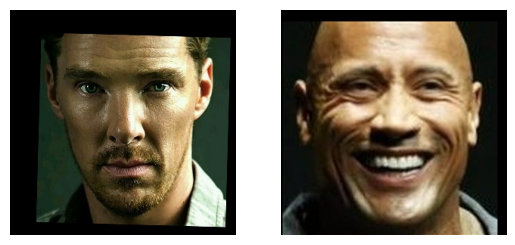

In [77]:
#Loading Test Image from the folder 
test_image_1 = load_image("D:/Course/Great Lakhs/Projects/8. Computer Vision/Project 2/Benedict Cumberbatch9.jpg")
test_image_2 = load_image("D:/Course/Great Lakhs/Projects/8. Computer Vision/Project 2/Dwayne Johnson4.jpg")

#plotting the Images
plt.subplot(1,2,1)
plt.imshow(test_image_1)
plt.axis(False)
plt.subplot(1,2,2)
plt.imshow(test_image_2)
plt.axis(False)
plt.show()

<span style="font-family:Ebrima; font-weight:bold;font-size:1.5em;color:#b44b97;">1 i - Use the trained SVM model to predict the face on both test images

In [78]:
#getting embedding vector for the Test Image 1
img_1 = test_image_1
img_1 = (img_1 / 255.).astype(np.float32)
img_1 = cv2.resize(img_1, dsize = (224,224))
embedding_vector_1 = vgg_face_descriptor.predict(np.expand_dims(img_1, axis=0))[0]

1/1 [==============================] - 3s 3s/step


In [84]:
#reshapeing the embedding vetor
img = embedding_vector_1.reshape(1,-1)

#standrddizing the embedding vector using the scaler function
img = scaler.transform(img)

#PCA the same 
X_pca = pca.transform(img)

#prediction using the SVM
predict = clf.predict(X_pca)

#identified image
print(f'Identified as {predict[0]}');

Identified as 5


In [75]:
#getting embedding vector for the Test Image 2
img_2 = test_image_2
img_2 = (img_2 / 255.).astype(np.float32)
img_2 = cv2.resize(img_2, dsize = (224,224))
embedding_vector_2 = vgg_face_descriptor.predict(np.expand_dims(img_2, axis=0))[0]

1/1 [==============================] - 1s 1s/step


In [83]:
#reshapeing the embedding vetor
img = embedding_vector_2.reshape(1,-1)

#standrddizing the embedding vector using the scaler function
img = scaler.transform(img)

#PCA the same 
X_pca = pca.transform(img)

#prediction using the SVM
predict = clf.predict(X_pca)

#identified image
print(f'Identified as {predict[0]}');

Identified as 19
